## 4 - The art of prediction
### Asking scientific questions of models

This week we have a very important topic to cover - using a model to generate predictions, and for us to test our scientific theories on those model-based predictions. 

This is likely one of the most important sessions we will cover, as it provides the basis for how to interact with models and have them answer our questons. We will cover:
- Generating conditional predictions from a model
- Generating marginal predictions and testing comparisons and slopes of those values
- Translating our natural-language queries into statistical terms


### The `marginaleffects` package
Much of the heavy lifting of our foray into predictions will be handled by a new package, called `marginaleffects`. This is a new Python package and can take a little getting used to, but it is very powerful. We'll explore how to use it and which of its functions we use to turn our questions into answers.

Lets import everything we need, including `marginaleffects`, which we will call `me`.

In [1]:
# Import most of what we need
import pandas as pd # dataframes
import seaborn as sns # plots
import statsmodels.formula.api as smf # Models
import marginaleffects as me # marginal effects

# Set the style for plots
sns.set_style('whitegrid') # a different theme!
sns.set_context('talk')

### Fitting a model
We will work through some examples with the `affairs` dataset, fitting models of varying complexity and using conditional and marginal predictions to understand the implications and answer our questions.

First, let's load in the dataset, and use `statsmodels` to fit a simple model, akin to a t-test, which looks at whether those with and without children have higher marital satisfaction:

In [2]:
# First read in the data
affairs = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/AER/Affairs.csv')

# Fit the simple model
simple_model = smf.ols('rating ~ children', data=affairs).fit()

# Simple summary
display(simple_model.summary(slim=True))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.037
No. Observations:                 601   F-statistic:                     24.00
Covariance Type:            nonrobust   Prob (F-statistic):           1.24e-06
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.2749      0.083     51.635      0.000       4.112       4.437
children[T.yes]    -0.4795      0.098     -4.899      0.000      -0.672      -0.287
===================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Using `marginaleffects` to get predictions
With a fitted model, lets see some of the ways we can use `marginaleffects` to get some results.

The first function is `me.predictions`, which is very general and returns a prediction for each datapoint that went into the data! Let's see how this works. `marginaleffects` returns a different type of dataframe (not a pandas one) so we just use the `to_pandas()` methods.

In [3]:
# Demonstrate prediction
me.predictions(simple_model).to_pandas().head(3) # Predict for the fitted model

,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
0,0,4.274854,0.082790,51.634708,0.0,inf,4.112588,4.437120,4,0,male,37.0,10.0,no,3,18,7,4
1,1,4.274854,0.082790,51.634708,0.0,inf,4.112588,4.437120,5,0,female,27.0,4.0,no,4,14,6,4
2,2,3.795349,0.052209,72.695638,0.0,inf,3.693022,3.897676,11,0,female,32.0,15.0,yes,1,12,1,4


Notice here we obtain, for each row/observation that went into the model:

- an estimate (the prediction)
- the std error
- the t-statistic
- the p-value (is it different from zero?)
- s-value (we can ignore)
- conf_low, conf_high - 95% confidence interval bounds

... and the rest of the dataset so we can see what went in!

This is great and can be very useful, but we want to use the model to *predict* an outcome for the values of its predictors. That is, we want to know, given someone has children, what is their satisfaction? What about if they do not have children? These are **conditional** predictions!

To do this, we have to ask the model to give us its predictions, given its inputs. We need to generate our inputs, which we can do using the very powerful `me.datagrid` function. Lets explore this.

### Generating inputs to get the right outputs
`me.datagrid` allows us to specify the values of the predictors we want the models outputs for, in a simple way. We use the `me.datagrid` function, and the first argument is the name of the model, and the remaining arguments are the names of the predictors and the values we'd like them to take, specified in a list (and the values *must* be the same as what went into the model).

So to generate a 'datagrid' (think - a set of questions we want to ask) for someone with and without children, we can do this:

In [4]:
# Demonstrate datagrid
inputs = me.datagrid(simple_model,
                     children=['yes', 'no'])

display(inputs.to_pandas())

,children,rownames,affairs,gender,age,yearsmarried,religiousness,education,occupation,rating
0,yes,807,0,female,32.487521,8.177696,4,14,5,5
1,no,807,0,female,32.487521,8.177696,4,14,5,5


This basically generates data, based on the original data the model saw, that varies only in the predictor we are interested in - see the `children` column has 'yes', and 'no', rows, but is the same on everything else. We can then pass this onto the `me.predictions` function as part of the `newdata` argument, and obtain our conditional predictions!

In [5]:
# Obtain conditional predictions
cond_pred = me.predictions(simple_model, newdata=inputs)
display(cond_pred.to_pandas())

,children,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,affairs,gender,age,yearsmarried,religiousness,education,occupation,rating
0,yes,0,3.795349,0.052209,72.695638,0.0,inf,3.693022,3.897676,807,0,female,32.487521,8.177696,4,14,5,5
1,no,1,4.274854,0.082790,51.634708,0.0,inf,4.112588,4.437120,807,0,female,32.487521,8.177696,4,14,5,5


The `estimate` column reveals those with children have lower happiness than those without. 

### Comparing predictions
We now see the mean satisfaction for marriage with children is 3.79, and without, it is 4.27. Now we may wish to know whether that difference is interesting. We can compare those values with a hypothesis test to work out the difference between them, and whether it is significant or not. This is achieved using the `hypothesis` argument, which takes varied inputs. We will see some complex ones later, but if we set this to the string `'pairwise'`, we will obtain a test of the difference between those predictions, as it will compare each row to every other row in the output!

In [6]:
# Difference between our predictions
me.predictions(simple_model, 
               newdata=inputs, 
               hypothesis='pairwise')

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""Row 1 - Row 2""",-0.479505,0.097877,-4.899035,9.6308e-7,19.985837,-0.671341,-0.287669


Amazingly and beautifully, this estimate is equal to the coefficient in the model! This is our test of interest, and we derived it entirely from a model - are those with children more satisfied in their marrige? No.

### More complex models, the same approach
While traditional approaches would require us to use our flow-chart to figure out which test to use, model-based inference makes tackling more complex problems easy. 

Lets extend the model to include the `yearsmarried` predictor. We will test whether the difference between those with and without children is present even when we adjust for the length of time they are married.

In [7]:
# Build a new model
model2 = smf.ols('rating ~ children + scale(yearsmarried)', data=affairs).fit() # note 'scale'
model2.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.061
No. Observations:                 601   F-statistic:                     20.43
Covariance Type:            nonrobust   Prob (F-statistic):           2.63e-09
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.0801      0.095     42.960      0.000       3.894       4.267
children[T.yes]        -0.2073      0.118     -1.758      0.079      -0.439       0.024
scale(yearsmarried)    -0.2144      0.053     -4.030      0.000      -0.319      -0.110
=======================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we want to make *marginal predictions*, that is a prediction while we hold other variables constant, we simply *leave out* the variables we want to hold constant. We repeat the same procedure as before:

In [8]:
# Make a datagrid of what we want to know
new_datagrid = me.datagrid(model2, children=['yes', 'no'], yearsmarried=[10]) # Notice NO yearsmarried variable
display('Predict this', new_datagrid)

# Model makes predictions on this
new_predictions = me.predictions(model2, newdata=new_datagrid)
display('Predictions', new_predictions)

# The contrast is done as before
contrast = me.predictions(model2, newdata=new_datagrid, hypothesis='pairwise')
display('The difference:', contrast)

'Predict this'

children,yearsmarried,rownames,affairs,gender,age,religiousness,education,occupation,rating
str,i64,i64,i64,str,f64,i64,i64,i64,i64
"""yes""",10,1843,0,"""female""",32.487521,4,14,5,5
"""no""",10,1843,0,"""female""",32.487521,4,14,5,5


'Predictions'

children,yearsmarried,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,affairs,gender,age,religiousness,education,occupation,rating
str,i64,i32,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,f64,i64,i64,i64,i64
"""yes""",10,0,3.802615,0.051589,73.710427,0.0,inf,3.701504,3.903727,1843,0,"""female""",32.487521,4,14,5,5
"""no""",10,1,4.009898,0.104915,38.220416,0.0,inf,3.804269,4.215528,1843,0,"""female""",32.487521,4,14,5,5


'The difference:'

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""Row 1 - Row 2""",-0.207283,0.117922,-1.757793,0.078783,3.665976,-0.438407,0.02384


### Exploring interactions with greater complexity
A huge bonus of this approach is that it makes answering complex questions seamless. Lets build a model that includes an interaction between children and gender, and includes the `yearsmarried` covariate. That is - whats the difference in marital satisfaction between men and women who do and dont have children, controlling for how long they have been married? 

This will introduce us to some subtle ways of working with the `me.predictions` and particularly the hypothesis approach.

In [9]:
# Specify the model
model3 = smf.ols('rating ~ gender * children + scale(yearsmarried)', data=affairs).fit()
display(model3.summary(slim=True))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.063
No. Observations:                 601   F-statistic:                     11.16
Covariance Type:            nonrobust   Prob (F-statistic):           9.72e-09
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          4.1985      0.120     35.013      0.000       3.963       4.434
gender[T.male]                    -0.2607      0.166     -1.572      0.116      -0.586       0.065
children[T.yes]                   -0.3860      0.150     -2.571      0.010      -0.681      -0.091
gender[T.male]:children[T.yes]     0.3751      0.196      1.917      0.056      -0.009       0.759
scale(yearsmarried)               -0.2049      0.053     -3.840      0.000      -0.310      -0.100
==================================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Build a datagrid to answer our question
datagrid3 = me.datagrid(model3, 
                        children=['yes', 'no'], 
                        gender=['male', 'female'])
display(datagrid3)

children,gender,rownames,affairs,age,yearsmarried,religiousness,education,occupation,rating
str,str,i64,i64,f64,f64,i64,i64,i64,i64
"""yes""","""male""",1304,0,32.487521,8.177696,4,14,5,5
"""yes""","""female""",1304,0,32.487521,8.177696,4,14,5,5
"""no""","""male""",1304,0,32.487521,8.177696,4,14,5,5
"""no""","""female""",1304,0,32.487521,8.177696,4,14,5,5


In [11]:
# Obtain predictions
predictions3 = me.predictions(model3, newdata=datagrid3)
display(predictions3)

children,gender,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,affairs,age,yearsmarried,religiousness,education,occupation,rating
str,str,i32,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64
"""yes""","""male""",0,3.926821,0.074764,52.522926,0.0,inf,3.780287,4.073356,1304,0,32.487521,8.177696,4,14,5,5
"""yes""","""female""",1,3.812441,0.075985,50.173871,0.0,inf,3.663514,3.961368,1304,0,32.487521,8.177696,4,14,5,5
"""no""","""male""",2,3.937813,0.132491,29.721272,0.0,inf,3.678134,4.197491,1304,0,32.487521,8.177696,4,14,5,5
"""no""","""female""",3,4.19849,0.119912,35.013104,0.0,inf,3.963467,4.433513,1304,0,32.487521,8.177696,4,14,5,5


We can make a plot of these if we like with `seaborn`.

<Axes: xlabel='children', ylabel='estimate'>

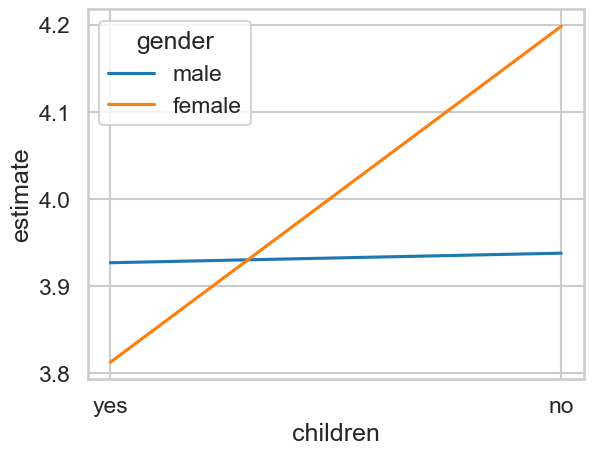

In [12]:
# visualise
sns.lineplot(data=predictions3,
             x='children', y='estimate',
             hue='gender')

The output of our predictions is essentially four rows, one for each combination of gender and child status (e.g. female with children, male without children, and so on). 

We can ask for specific differences here by indicating the *row labels* to compare and ask whether they are equal. The row labels are prefaced with the letter 'b'. This is a little confusing, so lets see how this works. Here are the predictions again:

In [13]:
# Predictions
me.predictions(model3, 
               newdata=datagrid3)

children,gender,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,affairs,age,yearsmarried,religiousness,education,occupation,rating
str,str,i32,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64
"""yes""","""male""",0,3.926821,0.074764,52.522926,0.0,inf,3.780287,4.073356,1304,0,32.487521,8.177696,4,14,5,5
"""yes""","""female""",1,3.812441,0.075985,50.173871,0.0,inf,3.663514,3.961368,1304,0,32.487521,8.177696,4,14,5,5
"""no""","""male""",2,3.937813,0.132491,29.721272,0.0,inf,3.678134,4.197491,1304,0,32.487521,8.177696,4,14,5,5
"""no""","""female""",3,4.19849,0.119912,35.013104,0.0,inf,3.963467,4.433513,1304,0,32.487521,8.177696,4,14,5,5


If I want to compare males with children (ROW 1) to males without children (ROW 3), then this is the way:

In [14]:
# A specific difference
me.predictions(model3, 
               newdata=datagrid3,
               hypothesis='b1 = b3')

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b1=b3""",-0.010991,0.156498,-0.070233,0.944008,0.083129,-0.317722,0.295739


Are there differences between females with and without children? That's row 2 and row 4, so:

In [15]:
# Another
me.predictions(model3, 
               newdata=datagrid3,
               hypothesis='b2 = b4')

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b2=b4""",-0.386049,0.150131,-2.571419,0.010128,6.625468,-0.6803,-0.091798


You might also be interested in the difference between men and women, averaged over whether they have children or not. You can ask `marginaleffects` to do this for you by including the variable you wish to target in the 'by' keyword. For example, if I want to see the predictions for men and women averaged across their child status, this is the way:

In [16]:
# Averaging over something
avg_over = me.predictions(model3,
                          newdata=datagrid3,
                          by='gender')
display(avg_over)

gender,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""female""",4.005465,0.066644,60.102161,0.0,inf,3.874845,4.136086
"""male""",3.932317,0.073817,53.271453,0.0,inf,3.787639,4.076995


Testing differences between *those* predictions proceeds as normal:

In [17]:
# Differences
me.predictions(model3,
               newdata=datagrid3,
               by='gender',
               hypothesis='b1=b2') # 'pairwise' also works here

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b1=b2""",0.073148,0.097444,0.750667,0.452853,1.142885,-0.117839,0.264136


### Exploring more interactions - categorical and continuous
What if we have categorical and continuous predictors interacting, and want to use our marginal effects to understand what is going on?

When we are working with continuous variables, we have two options - the comparison approach as we did above, or the simple slopes approach. Lets first explore the comparison approach.

#### Exploring more interactions - categorical and continuous - **comparisons** 
When working with continuous variables and predictions, we need to provide some candidate values across the range of the predictor for the model to work with. Lets see how this works by fitting a model that predicts marital satisfaction from the interaction of gender and years-married. That is, how does satisfaction change for females and males over the course of a marriage?

First we fit the model:

In [18]:
# New model
model4 = smf.ols('rating ~ gender * yearsmarried', data=affairs).fit()
model4.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.061
No. Observations:                 601   F-statistic:                     14.02
Covariance Type:            nonrobust   Prob (F-statistic):           7.68e-09
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.4470      0.105     42.374      0.000       4.241       4.653
gender[T.male]                 -0.2668      0.156     -1.715      0.087      -0.572       0.039
yearsmarried                   -0.0633      0.011     -5.902      0.000      -0.084      -0.042
gender[T.male]:yearsmarried     0.0325      0.016      2.069      0.039       0.002       0.063
===============================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We need to provide some values for `yearsmarried` for our model to predict for. What should we choose? There's no right or wrong answer - we might have some specific ideas in mind (e.g., 6 months, 2 years, 10 years, and 20 years), or we could provide something like the interquartile range for the `yearsmarried` variable and use those. Pandas can calculate that for us easily. Here we collect the 25th, 50th, and 75th percentiles of years married:

In [19]:
# Use pandas to get the quartiles
quartiles = affairs['yearsmarried'].quantile([.25, .5, .75])
display(quartiles)

0.25     4.0
0.50     7.0
0.75    15.0
Name: yearsmarried, dtype: float64

And now we pass those back into the datagrid approach, also asking for predictions on males and females:

In [20]:
# New datagrid
datagrid4 = me.datagrid(model4, 
                        gender=['male', 'female'],
                        yearsmarried=quartiles) # can pass right in

display(datagrid4)

gender,yearsmarried,rownames,affairs,age,children,religiousness,education,occupation,rating
str,f64,i64,i64,f64,str,i64,i64,i64,i64
"""male""",4.0,228,0,32.487521,"""yes""",4,14,5,5
"""male""",7.0,228,0,32.487521,"""yes""",4,14,5,5
"""male""",15.0,228,0,32.487521,"""yes""",4,14,5,5
"""female""",4.0,228,0,32.487521,"""yes""",4,14,5,5
"""female""",7.0,228,0,32.487521,"""yes""",4,14,5,5
"""female""",15.0,228,0,32.487521,"""yes""",4,14,5,5


And now we predict:

In [21]:
# Predict
predictions4 = me.predictions(model4, newdata=datagrid4)
display(predictions4)

gender,yearsmarried,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,affairs,age,children,religiousness,education,occupation,rating
str,f64,i32,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,str,i64,i64,i64,i64
"""male""",4.0,0,4.057067,0.080599,50.336419,0.0,inf,3.899096,4.215038,228,0,32.487521,"""yes""",4,14,5,5
"""male""",7.0,1,3.964758,0.065094,60.90815,0.0,inf,3.837176,4.09234,228,0,32.487521,"""yes""",4,14,5,5
"""male""",15.0,2,3.7186,0.099094,37.525923,0.0,inf,3.524379,3.912821,228,0,32.487521,"""yes""",4,14,5,5
"""female""",4.0,3,4.193857,0.074039,56.643673,0.0,inf,4.048742,4.338971,228,0,32.487521,"""yes""",4,14,5,5
"""female""",7.0,4,4.004036,0.061207,65.418089,0.0,inf,3.884073,4.123999,228,0,32.487521,"""yes""",4,14,5,5
"""female""",15.0,5,3.497848,0.096078,36.406417,0.0,inf,3.309539,3.686157,228,0,32.487521,"""yes""",4,14,5,5


We may choose to plot this for interpretability:

<Axes: xlabel='yearsmarried', ylabel='estimate'>

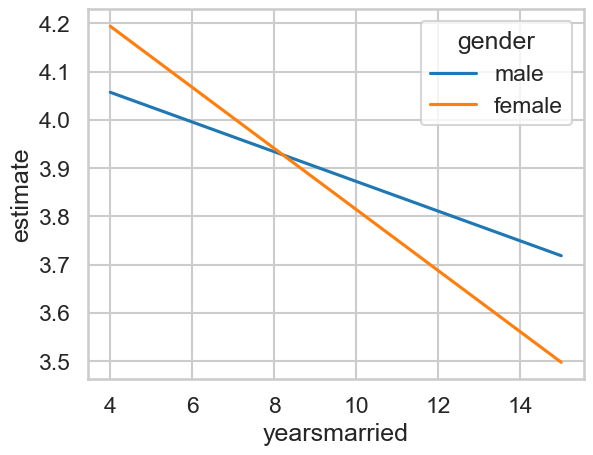

In [22]:
# Plot
sns.lineplot(data=predictions4,
             x='yearsmarried', y='estimate', 
             hue='gender')

Interpreting the comparisons now proceeds as before. Depending on our questions, we might want to know the differences between men and women at each time point. We do this simply by specifying our hypotheses. Once again here are the predictions:

In [23]:
# Predictions
display(predictions4)

gender,yearsmarried,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,affairs,age,children,religiousness,education,occupation,rating
str,f64,i32,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,str,i64,i64,i64,i64
"""male""",4.0,0,4.057067,0.080599,50.336419,0.0,inf,3.899096,4.215038,228,0,32.487521,"""yes""",4,14,5,5
"""male""",7.0,1,3.964758,0.065094,60.90815,0.0,inf,3.837176,4.09234,228,0,32.487521,"""yes""",4,14,5,5
"""male""",15.0,2,3.7186,0.099094,37.525923,0.0,inf,3.524379,3.912821,228,0,32.487521,"""yes""",4,14,5,5
"""female""",4.0,3,4.193857,0.074039,56.643673,0.0,inf,4.048742,4.338971,228,0,32.487521,"""yes""",4,14,5,5
"""female""",7.0,4,4.004036,0.061207,65.418089,0.0,inf,3.884073,4.123999,228,0,32.487521,"""yes""",4,14,5,5
"""female""",15.0,5,3.497848,0.096078,36.406417,0.0,inf,3.309539,3.686157,228,0,32.487521,"""yes""",4,14,5,5


Getting all the comparisons done in one go is a little clunky. We can do it one at a time, e.g:

`me.predictions(model4, newdata=datagrid4, hypothesis='b1=b4')`

or we could recall which rows we wanted to find the differences of (e.g. row 1 - row 4 compares men and women at 4 years of marriage, and ask for all the pairwise comparisons:


In [24]:
# Clunky comparisons
me.predictions(model4, 
               newdata=datagrid4,
               hypothesis='pairwise').to_pandas()

,term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
0,Row 1 - Row 2,0.092309,0.034453,2.679272,7.378243e-03,7.082507,0.024782,0.159836
1,Row 1 - Row 3,0.338467,0.126328,2.679272,7.378245e-03,7.082507,0.090869,0.586065
2,Row 1 - Row 4,-0.136790,0.109444,-1.249861,2.113505e-01,2.242291,-0.351296,0.077717
3,Row 1 - Row 5,0.053031,0.101205,0.523992,6.002839e-01,0.736283,-0.145328,0.251389
4,Row 1 - Row 6,0.559219,0.125408,4.459201,8.226583e-06,16.891275,0.313424,0.805014
5,Row 2 - Row 3,0.246158,0.091875,2.679272,7.378245e-03,7.082507,0.066086,0.426229
6,Row 2 - Row 4,-0.229099,0.098585,-2.323867,2.013263e-02,5.634321,-0.422323,-0.035875
7,Row 2 - Row 5,-0.039278,0.089351,-0.439598,6.602280e-01,0.598964,-0.214402,0.135845
8,Row 2 - Row 6,0.466910,0.116052,4.023267,5.739648e-05,14.088678,0.239451,0.694369
9,Row 3 - Row 4,-0.475257,0.123699,-3.842037,1.220176e-04,13.000623,-0.717702,-0.232811


This sort of approach is sometimes useful, but a cleaner technique is not to dwell on the individual predictions, but rather to look at the simple slopes!

#### Exploring more interactions - categorical and continuous - **slopes** 
When dealing with situations like this, its almost always better to focus instead on the simple slopes. These represent, quite literally, the slope the continuous variable has at *the level of another variable*, which might be continuous or categorical itself. Its akin to asking this question:

- How much does Y change with a 1-unit increase in X, when Z is fixed to a specific category?
Or, here:
- How much does marital satisfaction change when years married increases by 1 year, when gender is fixed to male or female?

This is a much cleaner approach as it removes the need to make lots of comparisons and instead directly checks the associations of a predictor and the dependent variable, fixing one variable at specific value. Lets see how this works, using the `me.slopes` function. First, examining the slopes visually makes it clear something is going on:

<Axes: xlabel='yearsmarried', ylabel='estimate'>

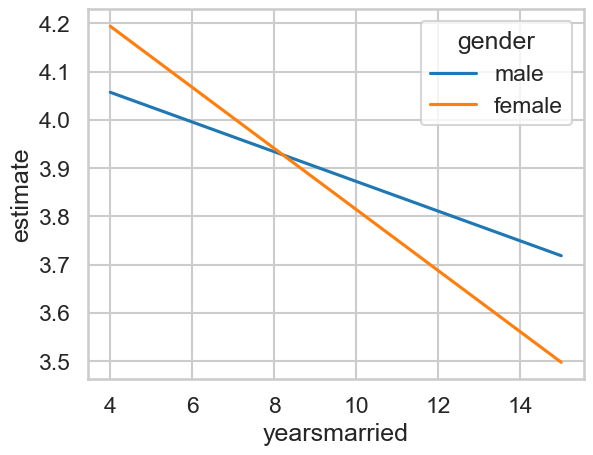

In [25]:
# Plot
sns.lineplot(data=predictions4,
             x='yearsmarried', y='estimate', 
             hue='gender')

Lets use `me.slopes` to work those out. Notice here we don't actually specify a new data grid, but simply say which variable to figure out the slopes for (`yearsmarried` in this case), and which variable to do this over (`gender`).

In [26]:
# slopes
slopes = me.slopes(model4, 
                   variables='yearsmarried', 
                   by='gender')
display(slopes)

gender,term,contrast,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,str,str,f64,f64,f64,f64,f64,f64,f64
"""female""","""yearsmarried""","""mean(dY/dX)""",-0.063274,0.010686,-5.921164,3.1967e-9,28.220764,-0.084218,-0.042329
"""male""","""yearsmarried""","""mean(dY/dX)""",-0.03077,0.011479,-2.680526,0.007351,7.087913,-0.053268,-0.008271


Aligned with the figure, females show a steeper decline than males (a more negative slope). We can ask whether there is a difference between those slopes in the usual way, e.g.

In [27]:
# Test for differences therein
me.slopes(model4, 
          variables='yearsmarried', 
          by='gender',
          hypothesis='pairwise')

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""Row 1 - Row 2""",-0.032504,0.015699,-2.070494,0.038406,4.702519,-0.063273,-0.001735


### Exploring more interactions - continuous and continuous!


Let us now consider a model that has an interaction between two continuous predictors, and how marginal predictions can help us interpret them. Here, we build a model that predicts marital satisfaction from number of years married and education. We are interested in whether those with more education and longer marriages are happier than those with less education.

First we fit the model:

In [28]:
# Model 5
model5 = smf.ols('rating ~ yearsmarried * education', data=affairs).fit()
model5.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.092
No. Observations:                 601   F-statistic:                     21.28
Covariance Type:            nonrobust   Prob (F-statistic):           4.17e-13
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.4446      0.589      9.246      0.000       4.288       6.601
yearsmarried              -0.2574      0.054     -4.798      0.000      -0.363      -0.152
education                 -0.0700      0.036     -1.919      0.056      -0.142       0.002
yearsmarried:education     0.0130      0.003      3.924      0.000       0.006       0.019
==========================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

How should we proceed in terms of inference, given we can see the interaction effect is significant?

Much like before, we can select some points on which to compare our variables, and try to interpret the differences between them.

Here, I've chosen to predict for marriages of lengths 1, 5, 10, and 20 years, and educational attainment of 10, 12, 18, and 20. 

In [29]:
# Create a datagrid
datagrid5 = me.datagrid(model5,
                        yearsmarried=[1, 5, 10, 20],
                        education=[10, 12, 18, 20])

# Generate predictions
predictions5 = me.predictions(model5, newdata=datagrid5)

Plotting these predictions will help visualise what's going on.

<Axes: xlabel='yearsmarried', ylabel='estimate'>

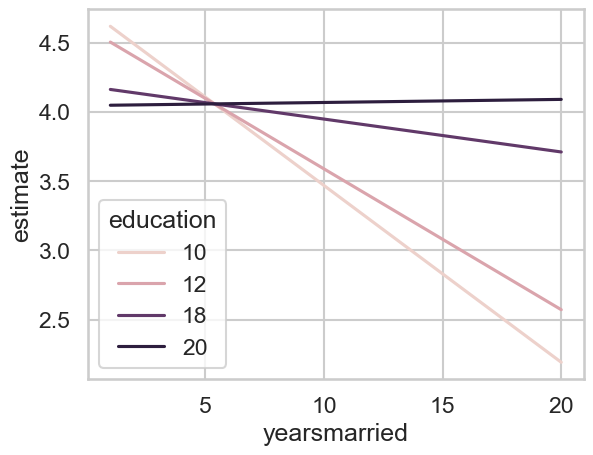

In [30]:
# Plot
sns.lineplot(data=predictions5, 
             x='yearsmarried', y='estimate',
             hue='education')

It is difficult to know where to begin! It is often simpler in these instances to pick one or two points and test differences. 

Lets say that we want to know whether the difference between educational attainment values 12 and 18 are significantly different at 10 and 20 years of marriage. That is achievable:

In [31]:
# Sensible predictions
display(me.predictions(model5, 
                       newdata=me.datagrid(model5, yearsmarried=[10, 20], education=[12, 18])
                      )
       )

yearsmarried,education,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,affairs,gender,age,children,religiousness,occupation,rating
i64,i64,i32,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,f64,str,i64,i64,i64
10,12,0,3.588739,0.087801,40.873459,0.0,inf,3.416652,3.760827,1418,0,"""female""",32.487521,"""yes""",4,5,5
10,18,1,3.947971,0.055455,71.192319,0.0,inf,3.839281,4.056661,1418,0,"""female""",32.487521,"""yes""",4,5,5
20,12,2,2.572324,0.189634,13.564647,0.0,inf,2.200648,2.944001,1418,0,"""female""",32.487521,"""yes""",4,5,5
20,18,3,3.71052,0.123796,29.972765,0.0,inf,3.467884,3.953156,1418,0,"""female""",32.487521,"""yes""",4,5,5


Repeat and actually test difference between rows 1 and 2 (married = 10, education varies):

In [32]:
# Testing one specific hypothesis
me.predictions(model5, 
               newdata=me.datagrid(model5, yearsmarried=[10], education=[12, 18]),
               hypothesis='b2=b1')

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b2=b1""",0.359231,0.107544,3.340332,0.000837,10.222862,0.14845,0.570013


In [33]:
# And repeats for another
me.predictions(model5, 
               newdata=me.datagrid(model5, yearsmarried=[20], education=[12, 18]),
               hypothesis='b2=b1')

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b2=b1""",1.138196,0.232581,4.893761,9.8927e-7,19.947132,0.682345,1.594046


Clearly a bigger difference at 20 years between the low and high education groups...

But what if you want to compare whether the *difference at 20 years between the education values* is *significantly bigger* than the difference *at 10 years?* Thats a neccessary and complex question, but you can ask it by actually performing the calculation with the `hypothesis` argument on the full set of comparisons. Lets see all the necessary predictions again first:

In [34]:
# These are the predictions
me.predictions(model5, 
               newdata=me.datagrid(model5,
                                   yearsmarried=[10, 20],
                                   education=[12, 18])
              )

yearsmarried,education,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,affairs,gender,age,children,religiousness,occupation,rating
i64,i64,i32,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,f64,str,i64,i64,i64
10,12,0,3.588739,0.087801,40.873459,0.0,inf,3.416652,3.760827,1930,0,"""female""",32.487521,"""yes""",4,5,5
10,18,1,3.947971,0.055455,71.192319,0.0,inf,3.839281,4.056661,1930,0,"""female""",32.487521,"""yes""",4,5,5
20,12,2,2.572324,0.189634,13.564647,0.0,inf,2.200648,2.944001,1930,0,"""female""",32.487521,"""yes""",4,5,5
20,18,3,3.71052,0.123796,29.972765,0.0,inf,3.467884,3.953156,1930,0,"""female""",32.487521,"""yes""",4,5,5


We specifically want to see whether the difference between rows 3 and 4 (years married = 20, education 12 and 18) is bigger than rows 1 and 2 (years married = 10, education 12 and 18). We can do that literally translating that query into a hypothesis.

In [35]:
# Answer the question!
me.predictions(model5, 
               newdata=me.datagrid(model5,
                                   yearsmarried=[10, 20],
                                   education=[12, 18]),
               hypothesis='b4-b3 = b2-b1'
              )

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b4-b3=b2-b1""",0.778964,0.198529,3.923689,0.000087,13.485259,0.389855,1.168073


This is indeed significant and reveals a closer insight into what the model understands. 

Of course, another approach is to compare slopes. We saw how to do this earlier in a continuous by categorical interaction situation, but here, everything is continuous.

The solution is essentially a combination of using a datagrid and the `slopes` command. We pick some candidate values for our predictors, generate a datagrid, and then compute the slopes for one over the other variable. 

To be explicit, first we will plot the slopes. I want the slopes for three levels of education - 9, 14, and 20. Call these low, medium, and high. I want these slopes for as many years married as we care to consider as we will be averaging over it soon enough. This looks like the below:

<Axes: xlabel='yearsmarried', ylabel='estimate'>

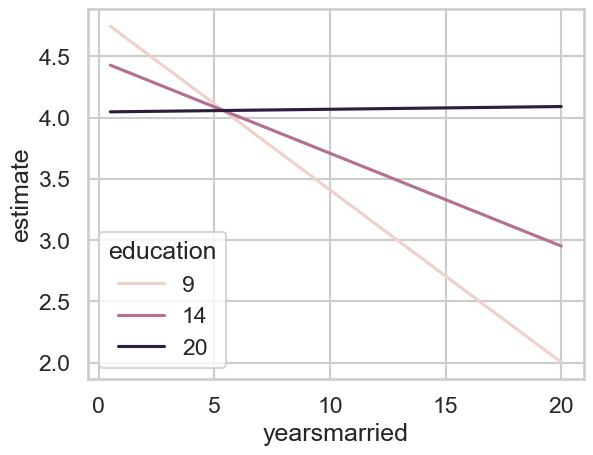

In [36]:
# Get our datagrid
slopes_datagrid = me.datagrid(model5, 
                              yearsmarried=[0.5, 1, 2, 3, 5, 10, 20],
                              education=[9, 14, 20])

# Predict them
p = me.predictions(model5, newdata=slopes_datagrid)

# Plot them
sns.lineplot(data=p,
             x='yearsmarried', y='estimate',
             hue='education')

What do we expect? The slope for an educational attainment of 20 is basically zero - a flat line! For 14, it is negative but not too steep, but for 9, it is very steep and negative. So lets obtain those three values and see how they look, which we do with a combination of our existing data grid and the variables/by arguments you've already seen:

In [37]:
# Slopes for ultimate insight
final_slopes = me.slopes(model5,
                         newdata=slopes_datagrid,
                         variables='yearsmarried', # average over this
                         by='education') # for each of these
final_slopes

education,term,contrast,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
i64,str,str,f64,f64,f64,f64,f64,f64,f64
9,"""yearsmarried""","""mean(dY/dX)""",-0.14059,0.024533,-5.730699,1.0002e-8,26.57517,-0.188673,-0.092506
14,"""yearsmarried""","""mean(dY/dX)""",-0.075676,0.010247,-7.385323,1.5210e-13,42.58004,-0.095759,-0.055593
20,"""yearsmarried""","""mean(dY/dX)""",0.00222,0.015143,0.146624,0.883429,0.178814,-0.02746,0.031901


The slope for an educational attainment of 20 is not significantly different from zero. As we predicted, for 14 its negative, and for 9, its much more steep. We can infact compare those if we want to using `hypothesis` - e.g - does the jump from 9 to 14 really slow your decline in marital satisfaction?

In [38]:
# Yes!
me.slopes(model5,
          newdata=slopes_datagrid,
          variables='yearsmarried', # average over this
          by='education', # for each of these
          hypothesis='b2 = b1')

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b2=b1""",0.064914,0.016538,3.925054,0.000087,13.493439,0.032499,0.097328


### Answering bespoke questions
You have seen so far how the model-based approach can answer some more complex questions than are usually posed and answered by psychology. We can now turn to an advanced use case, which is to use models to answer questions about individuals.

Imagine a female friend who has been married to her partner for 10 years, has a high level of educational attainment, and is aged 32. Her partner and her are considering having a child. She wants to know how this will change her marital happiness. How can we help? Traditional statistics in psychology cannot, despite this being a very psychologically based question. Our model can answer this for us. All we need do is build a model that considers the interactions of these variables, and have it predict two things.

The first should be our friends characteristics exactly as they are now. 
The second should be our friends altered characteristics, e.g., she then has a child.

Then we can work out the difference and provide an answer. Lets do this, using the exact same logic we have already seen.

First, the model.

In [43]:
# Fit the model with all variables in it
individual_mod = smf.ols('rating ~ gender * scale(yearsmarried) * scale(age) * scale(education) * children', data=affairs).fit()

# Create a datagrid that fits the profile
profile = me.datagrid(individual_mod,
                      gender='female',
                      yearsmarried=10,
                      age=32,
                      education=20,
                      children=['no', 'yes']
                     )

# Show the profile
display(profile)

gender,yearsmarried,age,education,children,rownames,affairs,religiousness,occupation,rating
str,i64,i64,i64,str,i64,i64,i64,i64,i64
"""female""",10,32,20,"""no""",172,0,4,5,5
"""female""",10,32,20,"""yes""",172,0,4,5,5


All we now need do is recover these predictions and examine the difference.

In [44]:
# Make the predictions
me.predictions(individual_mod, newdata=profile)

gender,yearsmarried,age,education,children,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,affairs,religiousness,occupation,rating
str,i64,i64,i64,str,i32,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64
"""female""",10,32,20,"""no""",0,3.233479,0.726611,4.450081,0.000009,16.829955,1.809347,4.65761,172,0,4,5,5
"""female""",10,32,20,"""yes""",1,4.414754,0.284761,15.503391,0.0,inf,3.856634,4.972875,172,0,4,5,5


And the contrast:

In [49]:
me.predictions(individual_mod, newdata=profile, hypothesis='b2=b1')

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b2=b1""",1.181275,0.780418,1.513644,0.130116,2.942129,-0.348316,2.710867


According to the model, while our friend would see a rather large jump in their satisfaction of 1.18 units, this is a very uncertain outcome, and is not statistically significant. 